## Battle of Neighborhoods in Toronto

---






### Import libraries:

In [0]:
import json
import folium
import requests
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from bs4 import BeautifulSoup
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.datasets.samples_generator import make_blobs
! git clone https://github.com/aminmb/Coursera_Capstone.git

Cloning into 'Coursera_Capstone'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 41 (delta 14), reused 23 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


# Data Collection:

### Scrape the wiki page for Toronto Neighbourhoods, Postal codes and Boroughs to extract the table and convert into Pandas dataframe:

In [0]:
webpage_neighbourhood = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup_neighbourhood = BeautifulSoup(webpage_neighbourhood.content,'lxml')
table_neighbourhood = soup_neighbourhood.find_all('table')[0]
postal_code_neighbourhood_df = pd.read_html(str(table_neighbourhood), header=0)[0]
postal_code_neighbourhood_df.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


### Scrape the wiki page for Toronto Subway stations to extract the table and convert into Pandas dataframe:

In [0]:
webpage_subway = requests.get("https://en.wikipedia.org/wiki/List_of_Toronto_subway_stations")
soup_subway = BeautifulSoup(webpage_subway.content,'lxml')
table_subway = soup_subway.find_all('table')[1]
neighbourhood_station_df = pd.read_html(str(table_subway), header=0)[0]
neighbourhood_station_df.head(10)

### Download the geospatial data into a data frame:

In [0]:
geo_data_url = "https://cocl.us/Geospatial_data"
!wget -q -O 'toronto_m.geospatial_data.csv' geo_data_url
postal_code_geo_df = pd.read_csv(geo_data_url)
postal_code_geo_df.head(10)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


In [0]:
community_df = pd.read_csv('Coursera_Capstone/wellbeing_toronto_community.csv')
community_df.head(10)

# Data Cleaning & Pre-Processing:


More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table:

In [0]:
postal_code_neighbourhood_df = postal_code_neighbourhood_df[(postal_code_neighbourhood_df.Borough != 'Not assigned')]
postal_code_neighbourhood_df.Neighbourhood.replace("Not assigned", postal_code_neighbourhood_df.Borough, inplace=True)
toronto_neighbourhood_df = postal_code_neighbourhood_df.set_index('Postcode').join(postal_code_geo_df.set_index('Postal Code'))
toronto_neighbourhood_df = toronto_neighbourhood_df.reset_index()
toronto_neighbourhood_df.head(10)

,index,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Rouge,43.806686,-79.194353
1,M1B,Scarborough,Malvern,43.806686,-79.194353
2,M1C,Scarborough,Highland Creek,43.784535,-79.160497
3,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
4,M1C,Scarborough,Port Union,43.784535,-79.160497
5,M1E,Scarborough,Guildwood,43.763573,-79.188711
6,M1E,Scarborough,Morningside,43.763573,-79.188711
7,M1E,Scarborough,West Hill,43.763573,-79.188711
8,M1G,Scarborough,Woburn,43.770992,-79.216917
9,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [0]:
postal_code_grouped_neighbourhood_df = postal_code_neighbourhood_df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(lambda x: ','.join(x.astype(str))).reset_index()
toronto_grouped_neighbourhood_df = postal_code_grouped_neighbourhood_df.set_index('Postcode').join(postal_code_geo_df.set_index('Postal Code'))
toronto_grouped_neighbourhood_df = toronto_grouped_neighbourhood_df.reset_index()
toronto_grouped_neighbourhood_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


In [0]:
print('The dataframe associated to Toronto has {} boroughs and {} neighbourhoods.'.format(
        len(postal_code_neighbourhood_df['Borough'].unique()),
        postal_code_neighbourhood_df.shape[0]
    )
)

The dataframe associated to Toronto has 11 boroughs and 211 neighbourhoods.


In [0]:
neighbourhood_station_df = neighbourhood_station_df[['Station', 'Grade', 'Accessible']]
neighbourhood_station_df.head(10)

NameError: ignored

### Create the map of Toronto using latitude and longitude values





Use geopy library to get the latitude and longitude values of Toronto.

In [0]:
address = 'Toronto, ON'

geo_locator_toronto = Nominatim(user_agent="toronto_agent")
location_toronto = geo_locator_toronto.geocode(address)
latitude_toronto = location_toronto.latitude
longitude_toronto = location_toronto.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [0]:
map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

for lat, lng, borough, neighborhood in zip(postal_code_neighbourhood_geo_df['Latitude'], postal_code_neighbourhood_geo_df['Longitude'], postal_code_neighbourhood_geo_df['Borough'], postal_code_neighbourhood_geo_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

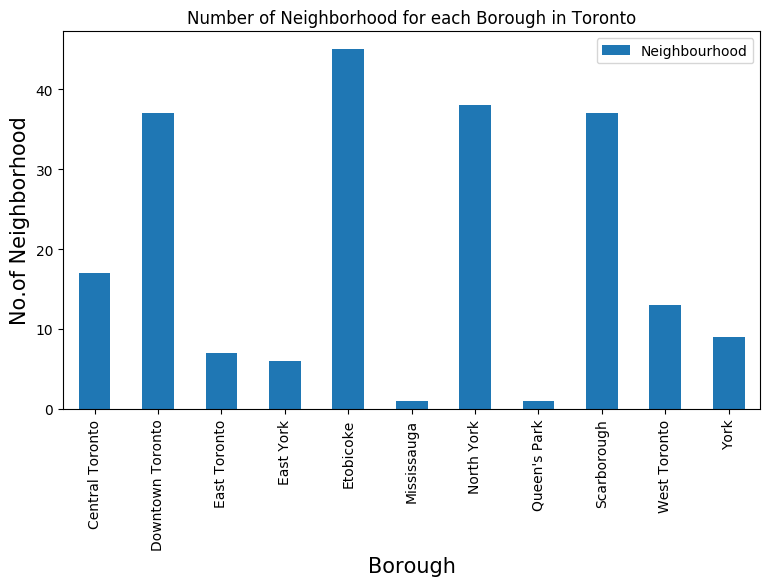

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in Toronto')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
toronto_neighbourhood_df.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
plt.legend()
plt.show()

## Explore the neighbourhood data


The url link to fetch the data from foursquare:

In [0]:
# CLIENT_ID = 'O00P4X5EZLFEM5ETRB0NST55RTYRRURKDWEJ5YIEAXO4ORPM'
CLIENT_ID = 'I3451FJ4ZJ2UT1KGJ1GP1ELLZUJ41TOGAFLNPXYGEQSEW5FG'
# CLIENT_SECRET = 'I2DK0RRZSAKXVOCHCQMDSXB5ENBAJNTINSLWKHBDNQ0I5DML'
CLIENT_SECRET = '4YUEEGXL1FWYVSVOBH4AHKFCJFAALIN0O32CTVCAWUXFOSY1'
VERSION = '20180605'
LIMIT = 100 
radius = 500 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_toronto, 
    longitude_toronto, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=I3451FJ4ZJ2UT1KGJ1GP1ELLZUJ41TOGAFLNPXYGEQSEW5FG&client_secret=4YUEEGXL1FWYVSVOBH4AHKFCJFAALIN0O32CTVCAWUXFOSY1&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

In [0]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

Find the nearby venues:

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
def get_venues(lat, lng):
    
    radius=1000
    LIMIT=100
    VERSION = '20180605' 
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
#     print(' ')
#     print(' ')
#     print(results)
    venue_data = results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [0]:
toronto_data = toronto_neighbourhood_df[['Borough', 'Neighbourhood', 'Latitude', 'Longitude' ]]
column_names = ['Borough', 'Neighbourhood', 'ID', 'Name']
restaurant_toronto_df = pd.DataFrame(columns=column_names)
count = 1
for row in toronto_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude = row
#     get_venues(Latitude, Longitude)
    venues = get_venues(Latitude, Longitude)
    resturants = venues[venues['Category'].str.contains("Restaurant")]   
    print('(', count, '/', len(toronto_data),')', 'Resturants in ' + Neighbourhood + ', ' + Borough + ':' + str(len(resturants)))
    for resturant_detail in resturants.values.tolist():
        id, name, category = resturant_detail
        restaurant_toronto_df = restaurant_toronto_df.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count += 1

( 1 / 211 ) Resturants in Rouge, Scarborough:5
( 2 / 211 ) Resturants in Malvern, Scarborough:5
( 3 / 211 ) Resturants in Highland Creek, Scarborough:1
( 4 / 211 ) Resturants in Rouge Hill, Scarborough:1
( 5 / 211 ) Resturants in Port Union, Scarborough:1
( 6 / 211 ) Resturants in Guildwood, Scarborough:3
( 7 / 211 ) Resturants in Morningside, Scarborough:3
( 8 / 211 ) Resturants in West Hill, Scarborough:3
( 9 / 211 ) Resturants in Woburn, Scarborough:3
( 10 / 211 ) Resturants in Cedarbrae, Scarborough:7
( 11 / 211 ) Resturants in Scarborough Village, Scarborough:5
( 12 / 211 ) Resturants in East Birchmount Park, Scarborough:5
( 13 / 211 ) Resturants in Ionview, Scarborough:5
( 14 / 211 ) Resturants in Kennedy Park, Scarborough:5
( 15 / 211 ) Resturants in Clairlea, Scarborough:3
( 16 / 211 ) Resturants in Golden Mile, Scarborough:3
( 17 / 211 ) Resturants in Oakridge, Scarborough:3
( 18 / 211 ) Resturants in Cliffcrest, Scarborough:3
( 19 / 211 ) Resturants in Cliffside, Scarborough:

In [0]:
restaurant_toronto_df.head(10)

,Borough,Neighbourhood,ID,Name
0,Scarborough,Rouge,4b914562f964a520d4ae33e3,Caribbean Wave
1,Scarborough,Rouge,579a91b3498e9bd833afa78a,Wendy's
2,Scarborough,Rouge,4bb6b9446edc76b0d771311c,Wendy's
3,Scarborough,Rouge,4b6718c2f964a5203f3a2be3,Harvey's
4,Scarborough,Rouge,4c706524df6b8cfab244b84d,Charley's Exotic Cuisine
5,Scarborough,Malvern,4b914562f964a520d4ae33e3,Caribbean Wave
6,Scarborough,Malvern,579a91b3498e9bd833afa78a,Wendy's
7,Scarborough,Malvern,4bb6b9446edc76b0d771311c,Wendy's
8,Scarborough,Malvern,4b6718c2f964a5203f3a2be3,Harvey's
9,Scarborough,Malvern,4c706524df6b8cfab244b84d,Charley's Exotic Cuisine


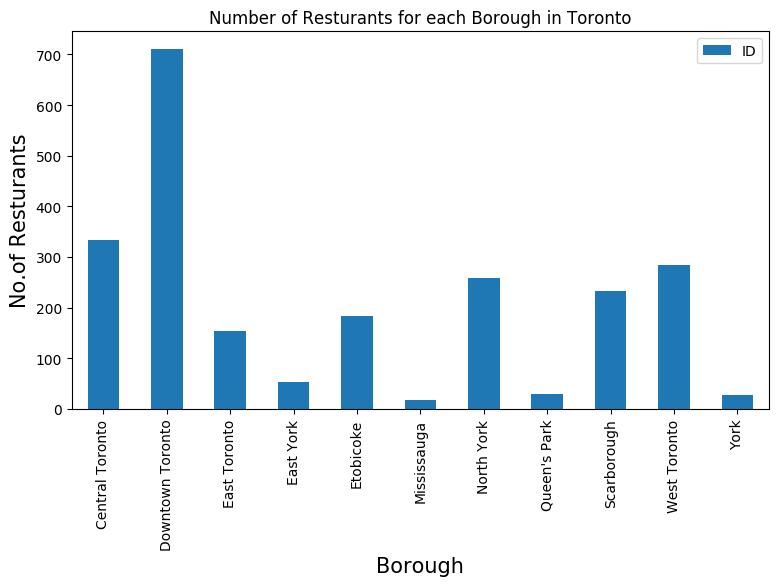

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Resturants for each Borough in Toronto')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Resturants', fontsize=15)
restaurant_toronto_df.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()


The above graph demonstratest that Downtown Toronto has the  largest number of resturants.

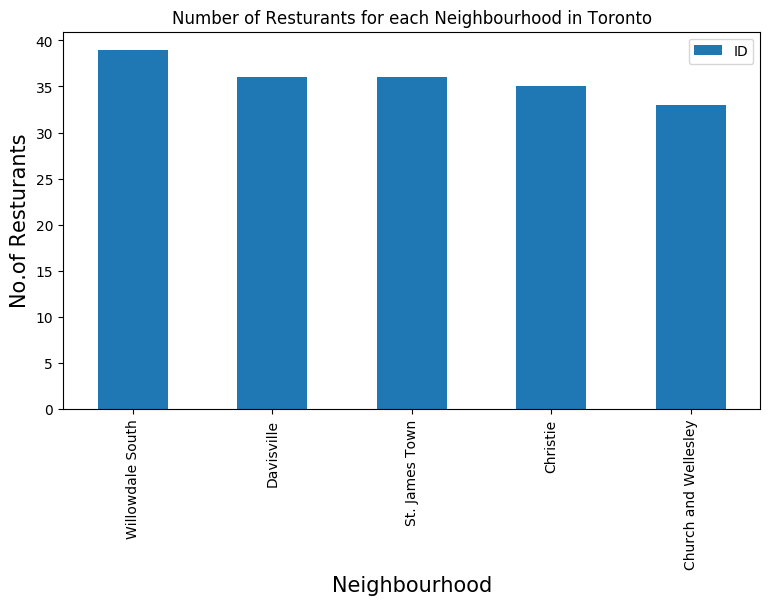

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Resturants for each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood', fontsize = 15)
plt.ylabel('No.of Resturants', fontsize=15)
restaurant_toronto_df.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

Also, Willowdale South has the largest number of resturants among all neighbourhoods.

In [0]:
restaurant_toronto_df[restaurant_toronto_df['Neighbourhood'] == 'Willowdale South']

,Borough,Neighbourhood,ID,Name
283,North York,Willowdale South,5a02789d0a464d3112a58785,Konjiki Ramen
284,North York,Willowdale South,563d44fccd1044ad67a744fb,The Captain's Boil
285,North York,Willowdale South,57f92db0498ee70159702002,Satay Sate
286,North York,Willowdale South,53c7201c498ef6785edb6856,Dakgogi
287,North York,Willowdale South,4c12ccc077cea59360c0cd60,Sushi Moto Sake & Wine Bar
288,North York,Willowdale South,4b2c1999f964a52098c124e3,Sushi Bong
289,North York,Willowdale South,4b2ea56cf964a52034e424e3,Owl of Minerva
290,North York,Willowdale South,4b5c97d1f964a520a83829e3,Buk Chang Dong Soon Tofu 북창동 순두부 돌솥밥
291,North York,Willowdale South,514bcaf7b0ede37f9e7d89d4,Jack Astor's Bar & Grill
292,North York,Willowdale South,5c86ca809411f20038d692fb,Blaze Pizza


In [0]:
def get_venue_details(venue_id):
        
    VERSION = '20180605' 
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [0]:
column_names = ['Borough', 'Neighbourhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
restaurant_toronto_stat_df = pd.DataFrame(columns=column_names)
count=1

for row in restaurant_toronto_df.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id= ', ID)
  
        id, name, likes, rating, tips = [0] * 5
    print('(', count, '/', len(restaurant_toronto_df), ')', 'processed')
    restaurant_toronto_stat_df = restaurant_toronto_stat_df.append({'Borough': Borough,
                                                'Neighbourhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID            Name  Likes  Rating  Tips
0  4b914562f964a520d4ae33e3  Caribbean Wave     10     6.6     8
( 1 / 2285 ) processed
                         ID     Name  Likes  Rating  Tips
0  579a91b3498e9bd833afa78a  Wendy's      1     6.1     1
( 2 / 2285 ) processed
                         ID     Name  Likes  Rating  Tips
0  4bb6b9446edc76b0d771311c  Wendy's      1     5.9     0
( 3 / 2285 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b6718c2f964a5203f3a2be3  Harvey's      9     6.3     5
( 4 / 2285 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id=  4c706524df6b8cfab244b84d
( 5 / 2285 ) processed
                         ID            Name  Likes  Rating  Tips
0  4b914562f964a520d4ae33e3  Caribbean Wave     10     6.6     8
( 6 / 2285 ) processed
                         ID     Name  Likes  Rating  Tips
0  579a91b3498e9bd833afa78a  Wendy's      1     6.1     1
( 7 / 2285 ) proc

KeyError: ignored

In [0]:
restaurant_toronto_stat_df.head(10)

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Scarborough,Rouge,4b914562f964a520d4ae33e3,Caribbean Wave,10,6.6,8
1,Scarborough,Rouge,579a91b3498e9bd833afa78a,Wendy's,1,6.1,1
2,Scarborough,Rouge,4bb6b9446edc76b0d771311c,Wendy's,1,5.9,0
3,Scarborough,Rouge,4b6718c2f964a5203f3a2be3,Harvey's,9,6.3,5
4,Scarborough,Rouge,0,0,0,0.0,0
5,Scarborough,Malvern,4b914562f964a520d4ae33e3,Caribbean Wave,10,6.6,8
6,Scarborough,Malvern,579a91b3498e9bd833afa78a,Wendy's,1,6.1,1
7,Scarborough,Malvern,4bb6b9446edc76b0d771311c,Wendy's,1,5.9,0
8,Scarborough,Malvern,4b6718c2f964a5203f3a2be3,Harvey's,9,6.3,5
9,Scarborough,Malvern,0,0,0,0.0,0


In [0]:
restaurant_toronto_stat_df.shape

(500, 7)

In [0]:
restaurant_toronto_df.shape

(2285, 4)

In [0]:
restaurant_toronto_stat_df.to_csv('restaurant_toronto_stat.csv', index=False)

In [0]:
restaurant_toronto_stat_csv_df = pd.read_csv('restaurant_toronto_stat.csv')
restaurant_toronto_stat_csv_df.shape

(500, 7)

In [0]:
restaurant_toronto_stat_csv_df.head(10)

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Scarborough,Rouge,4b914562f964a520d4ae33e3,Caribbean Wave,10,6.6,8
1,Scarborough,Rouge,579a91b3498e9bd833afa78a,Wendy's,1,6.1,1
2,Scarborough,Rouge,4bb6b9446edc76b0d771311c,Wendy's,1,5.9,0
3,Scarborough,Rouge,4b6718c2f964a5203f3a2be3,Harvey's,9,6.3,5
4,Scarborough,Rouge,0,0,0,0.0,0
5,Scarborough,Malvern,4b914562f964a520d4ae33e3,Caribbean Wave,10,6.6,8
6,Scarborough,Malvern,579a91b3498e9bd833afa78a,Wendy's,1,6.1,1
7,Scarborough,Malvern,4bb6b9446edc76b0d771311c,Wendy's,1,5.9,0
8,Scarborough,Malvern,4b6718c2f964a5203f3a2be3,Harvey's,9,6.3,5
9,Scarborough,Malvern,0,0,0,0.0,0


In [0]:
restaurant_toronto_stat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
Borough          500 non-null object
Neighbourhood    500 non-null object
ID               500 non-null object
Name             500 non-null object
Likes            500 non-null object
Rating           500 non-null float64
Tips             500 non-null object
dtypes: float64(1), object(6)
memory usage: 27.4+ KB


In [0]:
restaurant_toronto_stat_df['Likes'] = restaurant_toronto_stat_df['Likes'].astype('float64')
restaurant_toronto_stat_df['Tips'] = restaurant_toronto_stat_df['Tips'].astype('float64')
restaurant_toronto_stat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
Borough          500 non-null object
Neighbourhood    500 non-null object
ID               500 non-null object
Name             500 non-null object
Likes            500 non-null float64
Rating           500 non-null float64
Tips             500 non-null float64
dtypes: float64(3), object(4)
memory usage: 27.4+ KB


In [0]:
restaurant_toronto_stat_df.iloc[restaurant_toronto_stat_df['Likes'].idxmax()]

Borough                      East Toronto
Neighbourhood           The Danforth West
ID               4aeb268bf964a52006bf21e3
Name              Messini Authentic Gyros
Likes                                 190
Rating                                8.4
Tips                                   82
Name: 494, dtype: object

In [0]:
restaurant_toronto_stat_df.iloc[restaurant_toronto_stat_df['Rating'].idxmax()]

Borough                         East York
Neighbourhood                East Toronto
ID               5155ca12e4b0e05526806bdf
Name                             The Wren
Likes                                 132
Rating                                  9
Tips                                   48
Name: 465, dtype: object

In [0]:
restaurant_toronto_stat_df.iloc[restaurant_toronto_stat_df['Tips'].idxmax()]

Borough                        North York
Neighbourhood             Flemingdon Park
ID               4c02b933310fc9b64fe1c461
Name                       JOEY Don Mills
Likes                                 189
Rating                                8.5
Tips                                  128
Name: 341, dtype: object

In [0]:
toronto_neighborhood_stat_df = restaurant_toronto_stat_df.groupby('Neighbourhood', as_index=False).mean()[['Neighbourhood','Rating']]
toronto_neighborhood_stat_df.columns=['Neighbourhood','Average Rating']
toronto_neighborhood_stat_df.sort_values(['Average Rating'], ascending = False).head(10)

,Neighbourhood,Average Rating
54,The Danforth West,8.311111
35,Maryvale,7.775000
58,Wexford,7.775000
46,Rouge Hill,7.700000
44,Port Union,7.700000
27,Highland Creek,7.700000
4,Birch Cliff,7.325000
11,Cliffside West,7.325000
2,Bathurst Manor,7.320000
63,Wilson Heights,7.320000


In [0]:
toronto_borough_stat_df = restaurant_toronto_stat_df.groupby('Borough', as_index=False).mean()[['Borough','Rating']]
toronto_borough_stat_df.columns=['Borough','Average Rating']
toronto_borough_stat_df.sort_values(['Average Rating'], ascending=False).head()

,Borough,Average Rating
0,East Toronto,7.208333
2,North York,6.096842
3,Scarborough,5.705172
1,East York,4.942593


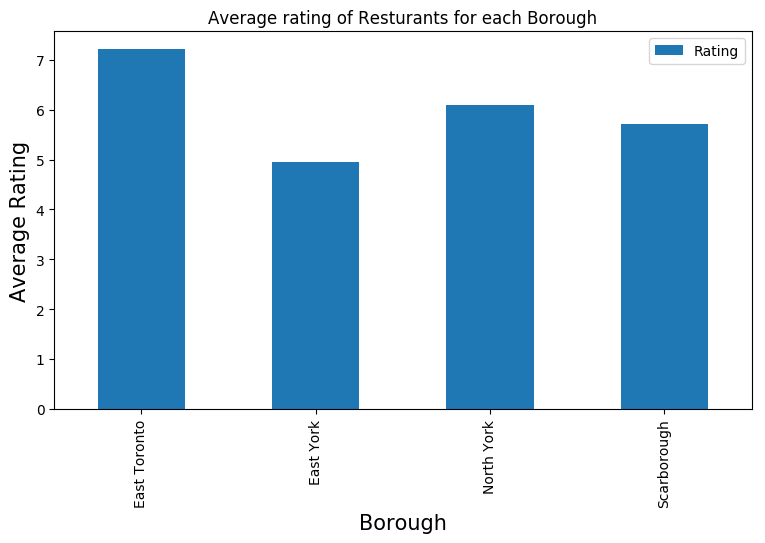

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
restaurant_toronto_stat_df.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

In [0]:
toronto_neighborhood_stat_df = toronto_neighborhood_stat_df[toronto_neighborhood_stat_df['Average Rating'] >= 7.0]
toronto_neighborhood_stat_df.sort_values(['Average Rating'], axis=0, ascending=False, inplace=True) 
toronto_neighborhood_stat_df

,Neighbourhood,Average Rating,index_x,Borough_x,Latitude_x,Longitude_x,index_y,Borough_y,Latitude_y,Longitude_y
9,The Danforth West,8.311111,M4K,East Toronto,43.679557,-79.352188,M4K,East Toronto,43.679557,-79.352188
6,Maryvale,7.775000,M1R,Scarborough,43.750072,-79.295849,M1R,Scarborough,43.750072,-79.295849
10,Wexford,7.775000,M1R,Scarborough,43.750072,-79.295849,M1R,Scarborough,43.750072,-79.295849
5,Highland Creek,7.700000,M1C,Scarborough,43.784535,-79.160497,M1C,Scarborough,43.784535,-79.160497
7,Port Union,7.700000,M1C,Scarborough,43.784535,-79.160497,M1C,Scarborough,43.784535,-79.160497
8,Rouge Hill,7.700000,M1C,Scarborough,43.784535,-79.160497,M1C,Scarborough,43.784535,-79.160497
1,Birch Cliff,7.325000,M1N,Scarborough,43.692657,-79.264848,M1N,Scarborough,43.692657,-79.264848
3,Cliffside West,7.325000,M1N,Scarborough,43.692657,-79.264848,M1N,Scarborough,43.692657,-79.264848
0,Bathurst Manor,7.320000,M3H,North York,43.754328,-79.442259,M3H,North York,43.754328,-79.442259
4,Downsview North,7.320000,M3H,North York,43.754328,-79.442259,M3H,North York,43.754328,-79.442259


In [0]:
toronto_neighborhood_stat_df = pd.merge(toronto_neighborhood_stat_df, toronto_neighbourhood_df, on='Neighbourhood')
toronto_neighborhood_stat_df.head(10)

,Neighbourhood,Average Rating,index_x,Borough_x,Latitude_x,Longitude_x,index_y,Borough_y,Latitude_y,Longitude_y
0,Bathurst Manor,7.320000,M3H,North York,43.754328,-79.442259,M3H,North York,43.754328,-79.442259
1,Birch Cliff,7.325000,M1N,Scarborough,43.692657,-79.264848,M1N,Scarborough,43.692657,-79.264848
2,Cedarbrae,7.128571,M1H,Scarborough,43.773136,-79.239476,M1H,Scarborough,43.773136,-79.239476
3,Cliffside West,7.325000,M1N,Scarborough,43.692657,-79.264848,M1N,Scarborough,43.692657,-79.264848
4,Downsview North,7.320000,M3H,North York,43.754328,-79.442259,M3H,North York,43.754328,-79.442259
5,Highland Creek,7.700000,M1C,Scarborough,43.784535,-79.160497,M1C,Scarborough,43.784535,-79.160497
6,Maryvale,7.775000,M1R,Scarborough,43.750072,-79.295849,M1R,Scarborough,43.750072,-79.295849
7,Port Union,7.700000,M1C,Scarborough,43.784535,-79.160497,M1C,Scarborough,43.784535,-79.160497
8,Rouge Hill,7.700000,M1C,Scarborough,43.784535,-79.160497,M1C,Scarborough,43.784535,-79.160497
9,The Danforth West,8.311111,M4K,East Toronto,43.679557,-79.352188,M4K,East Toronto,43.679557,-79.352188


In [0]:
address = 'Toronto, ON'

geo_locator_toronto = Nominatim(user_agent="toronto_agent")
location_toronto = geo_locator_toronto.geocode(address)
latitude_toronto = location_toronto.latitude
longitude_toronto = location_toronto.longitude

map_toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto_neighborhood_stat_df['Latitude_x'], toronto_neighborhood_stat_df['Longitude_x'], toronto_neighborhood_stat_df['Borough_x'], toronto_neighborhood_stat_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Conclusion:



*  The following neighbourhods are the best neighborhoods for restaurants:


       *   The Danforth West	   8.311
       *   Maryvale	             7.775
       *   Wexford	             7.775
       *   Rouge Hill	           7.700
       * . Port Union	           7.700

*  Among all boroughs,  ***East Toronto*** have potential for opening new Resturants.
